In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


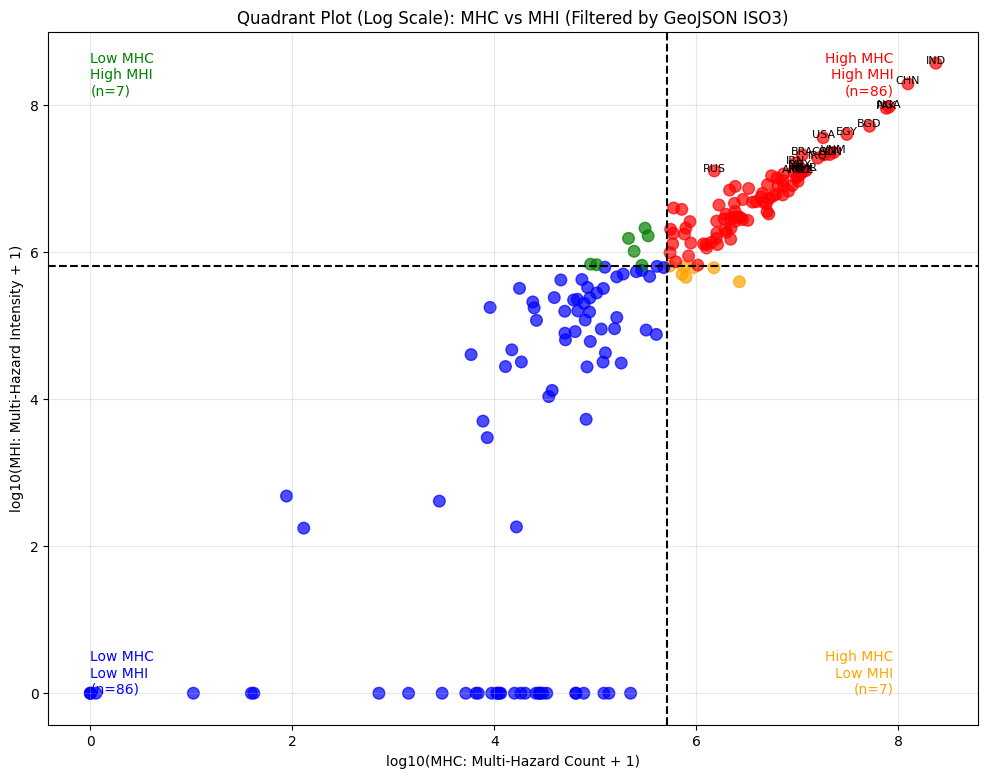

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

# 1️⃣ Load GeoJSON
geojson_file = '/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/CCRI_P1_P2_format.geojson'
gdf = gpd.read_file(geojson_file)

# Clean iso3
geo_iso3 = gdf['iso3'].astype(str).str.strip()

# 2️⃣ Load MHI and MHC data
file_mhi = '/content/drive/MyDrive/CCRI/ccri_repo/data/misc/MHI_stat_climate.csv'  # MHI
file_mhc = '/content/drive/MyDrive/CCRI/ccri_repo/data/misc/MHC_climate_stat.csv'  # MHC

df_mhi = pd.read_csv(file_mhi, usecols=['ISO3', 'child_population_exposed_80'])
df_mhc = pd.read_csv(file_mhc, usecols=['ISO3', 'ge3_topics'])

# Merge MHI and MHC
df = df_mhi.merge(df_mhc, on='ISO3', how='inner').dropna()

# 3️⃣ Filter only ISO3 present in GeoJSON
df = df[df['ISO3'].isin(geo_iso3)]

# 4️⃣ Log-transform
df['log_mhc'] = np.log10(df['ge3_topics'] + 1)          # X-axis
df['log_mhi'] = np.log10(df['child_population_exposed_80'] + 1)  # Y-axis

# 5️⃣ Compute thresholds (median)
x_thr = df['log_mhc'].median()
y_thr = df['log_mhi'].median()

# 6️⃣ Assign quadrant colors
def quadrant_color(x, y):
    if x >= x_thr and y >= y_thr:
        return 'red'    # High MHC, High MHI
    elif x >= x_thr and y < y_thr:
        return 'orange' # High MHC, Low MHI
    elif x < x_thr and y >= y_thr:
        return 'green'  # Low MHC, High MHI
    else:
        return 'blue'   # Low MHC, Low MHI

df['color'] = df.apply(lambda r: quadrant_color(r['log_mhc'], r['log_mhi']), axis=1)

# 7️⃣ Compute quadrant counts
counts = {
    'High-High': len(df[(df['log_mhc'] >= x_thr) & (df['log_mhi'] >= y_thr)]),
    'High-Low': len(df[(df['log_mhc'] >= x_thr) & (df['log_mhi'] < y_thr)]),
    'Low-High': len(df[(df['log_mhc'] < x_thr) & (df['log_mhi'] >= y_thr)]),
    'Low-Low': len(df[(df['log_mhc'] < x_thr) & (df['log_mhi'] < y_thr)])
}

# 8️⃣ Plot quadrant
plt.figure(figsize=(12, 9))
plt.scatter(df['log_mhc'], df['log_mhi'], c=df['color'], alpha=0.7, s=70)

# Quadrant lines
plt.axvline(x=x_thr, color='black', linestyle='--')
plt.axhline(y=y_thr, color='black', linestyle='--')

# Quadrant labels with counts
plt.text(df['log_mhc'].max()*0.95, df['log_mhi'].max()*0.95, f'High MHC\nHigh MHI\n(n={counts["High-High"]})',
         ha='right', fontsize=10, color='red')
plt.text(df['log_mhc'].max()*0.95, df['log_mhi'].min()*1.05, f'High MHC\nLow MHI\n(n={counts["High-Low"]})',
         ha='right', fontsize=10, color='orange')
plt.text(df['log_mhc'].min()*1.05, df['log_mhi'].max()*0.95, f'Low MHC\nHigh MHI\n(n={counts["Low-High"]})',
         ha='left', fontsize=10, color='green')
plt.text(df['log_mhc'].min()*1.05, df['log_mhi'].min()*1.05, f'Low MHC\nLow MHI\n(n={counts["Low-Low"]})',
         ha='left', fontsize=10, color='blue')

# Label top 20 countries by MHI
top20 = df.nlargest(20, 'child_population_exposed_80')
for i, row in top20.iterrows():
    plt.text(row['log_mhc'], row['log_mhi'], row['ISO3'], fontsize=8, ha='center')

# Labels and title
plt.xlabel('log10(MHC: Multi-Hazard Count + 1)')
plt.ylabel('log10(MHI: Multi-Hazard Intensity + 1)')
plt.title('Quadrant Plot (Log Scale): MHC vs MHI (Filtered by GeoJSON ISO3)')

plt.grid(alpha=0.3)
plt.show()


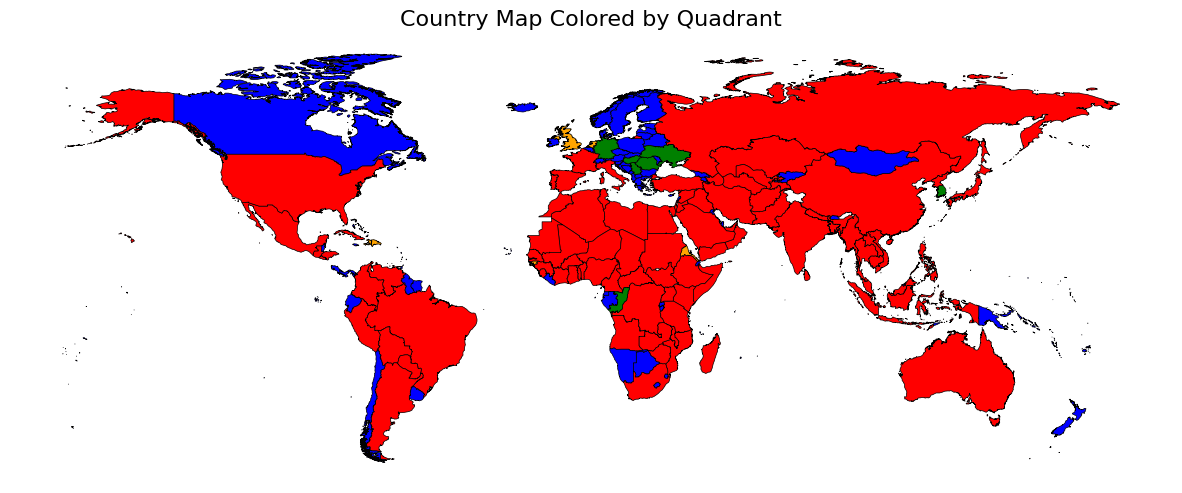

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load GeoJSON
geojson_file = '/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/CCRI_P1_P2_format.geojson'
gdf = gpd.read_file(geojson_file)

# Ensure iso3 in GeoJSON and df are clean strings
gdf['iso3'] = gdf['iso3'].astype(str).str.strip()
df['ISO3'] = df['ISO3'].astype(str).str.strip()

# Merge GeoDataFrame with df using lowercase 'iso3'
gdf_merged = gdf.merge(df[['ISO3', 'color']], left_on='iso3', right_on='ISO3', how='left')

# Plot map colored by quadrant
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf_merged.plot(color=gdf_merged['color'], edgecolor='black', linewidth=0.5, ax=ax)

# Optional: remove axes and add title
ax.set_axis_off()
plt.title('Country Map Colored by Quadrant', fontsize=16)
plt.show()


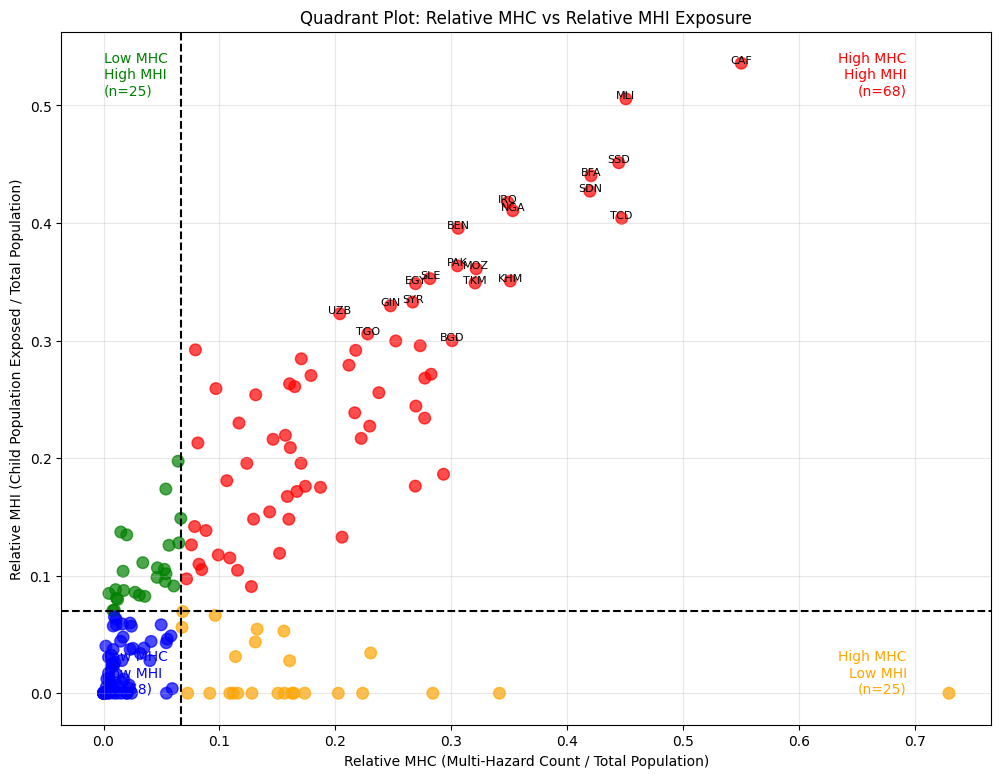

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# 1️⃣ Load GeoJSON
geojson_file = '/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/CCRI_P1_P2_format.geojson'
gdf = gpd.read_file(geojson_file)

# Clean iso3 and total population
gdf['iso3'] = gdf['iso3'].astype(str).str.strip()
gdf['total_pop'] = pd.to_numeric(gdf['total_pop'], errors='coerce')

# 2️⃣ Load MHI and MHC data
file_mhi = '/content/drive/MyDrive/CCRI/ccri_repo/data/misc/MHI_stat_climate.csv'  # MHI
file_mhc = '/content/drive/MyDrive/CCRI/ccri_repo/data/misc/MHC_climate_stat.csv'  # MHC

df_mhi = pd.read_csv(file_mhi, usecols=['ISO3', 'child_population_exposed_80'])
df_mhc = pd.read_csv(file_mhc, usecols=['ISO3', 'ge3_topics'])

# Merge MHI and MHC
df = df_mhi.merge(df_mhc, on='ISO3', how='inner').dropna()

# 3️⃣ Filter only countries present in GeoJSON
df = df[df['ISO3'].isin(gdf['iso3'])]

# 4️⃣ Merge total_pop from GeoJSON
df = df.merge(gdf[['iso3','adm_name', 'total_pop']], left_on='ISO3', right_on='iso3', how='left')

# 5️⃣ Compute relative exposures
df['rel_mhi'] = df['child_population_exposed_80'] / df['total_pop']
df['rel_mhc'] = df['ge3_topics'] / df['total_pop']

# 6️⃣ Compute thresholds (median) for quadrants
x_thr = df['rel_mhc'].median()
y_thr = df['rel_mhi'].median()

# 7️⃣ Assign quadrant colors
def quadrant_color(x, y):
    if x >= x_thr and y >= y_thr:
        return 'red'    # High MHC, High MHI
    elif x >= x_thr and y < y_thr:
        return 'orange' # High MHC, Low MHI
    elif x < x_thr and y >= y_thr:
        return 'green'  # Low MHC, High MHI
    else:
        return 'blue'   # Low MHC, Low MHI

df['color'] = df.apply(lambda r: quadrant_color(r['rel_mhc'], r['rel_mhi']), axis=1)

# 8️⃣ Quadrant counts
counts = {
    'High-High': len(df[(df['rel_mhc'] >= x_thr) & (df['rel_mhi'] >= y_thr)]),
    'High-Low': len(df[(df['rel_mhc'] >= x_thr) & (df['rel_mhi'] < y_thr)]),
    'Low-High': len(df[(df['rel_mhc'] < x_thr) & (df['rel_mhi'] >= y_thr)]),
    'Low-Low': len(df[(df['rel_mhc'] < x_thr) & (df['rel_mhi'] < y_thr)])
}

# 9️⃣ Plot quadrant
plt.figure(figsize=(12, 9))
plt.scatter(df['rel_mhc'], df['rel_mhi'], c=df['color'], alpha=0.7, s=70)

# Quadrant lines
plt.axvline(x=x_thr, color='black', linestyle='--')
plt.axhline(y=y_thr, color='black', linestyle='--')

# Quadrant labels with counts
plt.text(df['rel_mhc'].max()*0.95, df['rel_mhi'].max()*0.95,
         f'High MHC\nHigh MHI\n(n={counts["High-High"]})', ha='right', fontsize=10, color='red')
plt.text(df['rel_mhc'].max()*0.95, df['rel_mhi'].min()*1.05,
         f'High MHC\nLow MHI\n(n={counts["High-Low"]})', ha='right', fontsize=10, color='orange')
plt.text(df['rel_mhc'].min()*1.05, df['rel_mhi'].max()*0.95,
         f'Low MHC\nHigh MHI\n(n={counts["Low-High"]})', ha='left', fontsize=10, color='green')
plt.text(df['rel_mhc'].min()*1.05, df['rel_mhi'].min()*1.05,
         f'Low MHC\nLow MHI\n(n={counts["Low-Low"]})', ha='left', fontsize=10, color='blue')

# Label top 20 countries by relative MHI
top20 = df.nlargest(20, 'rel_mhi')
for i, row in top20.iterrows():
    plt.text(row['rel_mhc'], row['rel_mhi'], row['ISO3'], fontsize=8, ha='center')

# Labels and title
plt.xlabel('Relative MHC (Multi-Hazard Count / Total Population)')
plt.ylabel('Relative MHI (Child Population Exposed / Total Population)')
plt.title('Quadrant Plot: Relative MHC vs Relative MHI Exposure')

plt.grid(alpha=0.3)
plt.show()


In [ ]:
top20

,ISO3,child_population_exposed_80,ge3_topics,iso3,adm_name,total_pop,rel_mhi,rel_mhc,color
27,CAF,2.776503e+06,2.851435e+06,CAF,Central African Republic,5180633.0,0.535939,0.550403,red
110,MLI,1.219793e+07,1.087624e+07,MLI,Mali,24125255.0,0.505608,0.450824,red
151,SSD,5.324898e+06,5.246986e+06,SSD,South Sudan,11799866.0,0.451268,0.444665,red
13,BFA,1.025497e+07,9.799840e+06,BFA,Burkina Faso,23295775.0,0.440207,0.420670,red
143,SDN,2.130050e+07,2.093592e+07,SDN,Sudan,49878063.0,0.427052,0.419742,red
78,IRQ,1.902835e+07,1.589447e+07,IRQ,Iraq,45558485.0,0.417669,0.348881,red
122,NGA,9.424777e+07,8.110043e+07,NGA,Nigeria,229602955.0,0.410482,0.353220,red
160,TCD,8.038329e+06,8.895579e+06,TCD,Chad,19892914.0,0.404080,0.447173,red
12,BEN,5.650302e+06,4.372822e+06,BEN,Benin,14286070.0,0.395511,0.306090,red
129,PAK,9.043782e+07,7.596548e+07,PAK,Pakistan,248748129.0,0.363572,0.305391,red


In [ ]:
df

,ISO3,child_population_exposed_80,ge3_topics,iso3,total_pop,rel_mhi,rel_mhc,color
0,AFG,1.225378e+07,9.143163e+06,AFG,42009525.0,0.291690,0.217645,red
1,AGO,5.205267e+06,2.884413e+06,AGO,36705527.0,0.141812,0.078583,red
2,ALB,1.587490e+05,6.690942e+04,ALB,2785088.0,0.057000,0.024024,blue
3,AND,0.000000e+00,0.000000e+00,AND,81413.0,0.000000,0.000000,blue
4,ARE,1.268010e+06,1.618655e+06,ARE,10654431.0,0.119012,0.151923,red
...,...,...,...,...,...,...,...,...
181,WSM,0.000000e+00,3.013603e+04,WSM,193052.0,0.000000,0.156103,orange
182,YEM,3.560385e+06,5.006473e+06,YEM,39243002.0,0.090727,0.127576,red
183,ZAF,6.981103e+06,2.130583e+06,ZAF,62854816.0,0.111067,0.033897,green
184,ZMB,2.644878e+06,1.588333e+06,ZMB,20958247.0,0.126198,0.075786,red


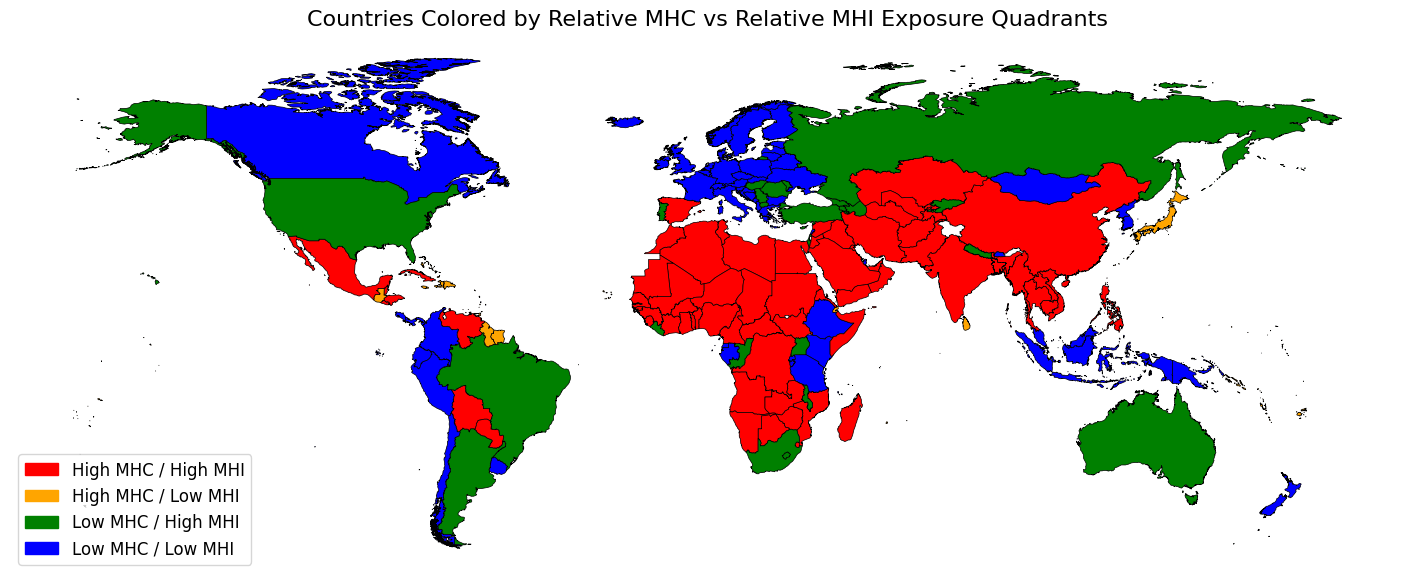

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# 1️⃣ Load GeoJSON
geojson_file = '/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/CCRI_P1_P2_format.geojson'
gdf = gpd.read_file(geojson_file)

# Clean iso3 and total_pop
gdf['iso3'] = gdf['iso3'].astype(str).str.strip()
gdf['total_pop'] = pd.to_numeric(gdf['total_pop'], errors='coerce')

# 2️⃣ Merge relative exposures from df
# df should have 'ISO3', 'rel_mhi', 'rel_mhc', 'color'
gdf_merged = gdf.merge(df[['ISO3', 'rel_mhi', 'rel_mhc', 'color']], left_on='iso3', right_on='ISO3', how='left')

# 3️⃣ Plot map
fig, ax = plt.subplots(1, 1, figsize=(18, 12))
gdf_merged.plot(color=gdf_merged['color'], edgecolor='black', linewidth=0.5, ax=ax)

# Optional: remove axes and add title
ax.set_axis_off()
plt.title('Countries Colored by Relative MHC vs Relative MHI Exposure Quadrants', fontsize=16)

# 4️⃣ Add manual legend for quadrants
import matplotlib.patches as mpatches
legend_patches = [
    mpatches.Patch(color='red', label='High MHC / High MHI'),
    mpatches.Patch(color='orange', label='High MHC / Low MHI'),
    mpatches.Patch(color='green', label='Low MHC / High MHI'),
    mpatches.Patch(color='blue', label='Low MHC / Low MHI'),
]
ax.legend(handles=legend_patches, loc='lower left', fontsize=12)

plt.show()


In [ ]:
import pandas as pd
mhc_mhi_df = pd.read_csv('/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/Child_weighted_MHC_MHI_by_country.csv')

In [ ]:
mhc = mhc_mhi_df['mean_MHC_child_weighted']
mhi = mhc_mhi_df['mean_MHI_child_weighted']

In [ ]:
gdf

,iso3,adm_name,total_pop,u18_pop,wb_income,unicef_ro,ucode,uuid,type,fragile,...,mhc_ge1_rel,mhc_ge2_rel,mhc_ge3_rel,mhc_ge4_rel,mhc_ge5_rel,mhc_ge6_rel,mhc_ge7_rel,mhc_ge8_rel,ccri,geometry
0,AND,Andorra,81413.0,12305.0,HI,None,AND_V1,0edb2089-1dfc-42cd-a7d8-ccdd7456b358,State,None,...,100.00,51.87,0.00,0.00,0.00,0.00,0.00,0.0,1.57,"POLYGON ((1.44256 42.60367, 1.44601 42.52099, ..."
1,AGO,Angola,36705527.0,18709837.0,LMI,ESARO,AGO_V1,606f8a40-9a97-4198-b75a-7f279b5ce3be,State,fragile,...,96.76,65.37,15.42,1.51,0.05,0.00,0.00,0.0,6.07,"MULTIPOLYGON (((11.66938 -16.56043, 11.70349 -..."
2,AFG,Afghanistan,42009525.0,20941094.0,LI,ROSA,AFG_V1,f82a5059-81e7-4d93-8adb-7b1cc1b40a49,State,fragile,...,97.79,81.72,43.66,7.43,0.64,0.01,0.00,0.0,5.89,"POLYGON ((60.5211 34.10096, 60.52862 34.03797,..."
3,ARE,United Arab Emirates,10654431.0,2031448.0,HI,MENARO,ARE_V1,477c1beb-5c15-465d-a311-b84850dca9f4,State,None,...,96.20,92.78,79.68,12.04,1.56,0.00,0.00,0.0,3.55,"MULTIPOLYGON (((54.2942 24.39753, 54.315 24.31..."
4,ARM,Armenia,2985307.0,692306.0,UMI,ECARO,ARM_V1,bf63c212-9792-4b8a-9040-75654194c788,State,None,...,94.62,51.29,3.46,0.32,0.02,0.00,0.00,0.0,1.64,"POLYGON ((43.46854 41.0306, 43.49392 41.01885,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,YEM,Yemen,39243002.0,18647028.0,LI,MENARO,YEM_V1,a19de85e-6d3a-4798-b263-7c1cad86bb0a,State,fragile,...,100.00,63.08,26.85,8.61,0.69,0.02,0.00,0.0,5.69,"MULTIPOLYGON (((52.9797 12.16689, 53.03243 12...."
182,VUT,Vanuatu,281242.0,141923.0,LMI,EAPRO,VUT_V1,8ea117e3-ecc0-42c5-82ca-f237b1b2d8ca,State,None,...,100.00,98.21,18.17,0.25,0.00,0.00,0.00,0.0,3.56,"MULTIPOLYGON (((167.29029 -13.53564, 167.33636..."
183,VNM,Viet Nam,100066740.0,28020535.0,LMI,EAPRO,VNM_V1,442222e8-13e7-4984-97ff-5f3a399bb14c,State,None,...,99.08,95.88,82.05,58.62,29.78,5.92,0.06,0.0,5.41,"MULTIPOLYGON (((106.64309 8.58014, 106.69451 8..."
184,UGA,Uganda,49309225.0,25129259.0,LI,ESARO,UGA_V1,9bd07a97-abca-416f-9121-8e9b5a75a63f,State,fragile,...,100.00,85.12,13.08,3.10,0.02,0.00,0.00,0.0,4.61,"POLYGON ((30.86298 3.4862, 30.86281 3.48133, 3..."


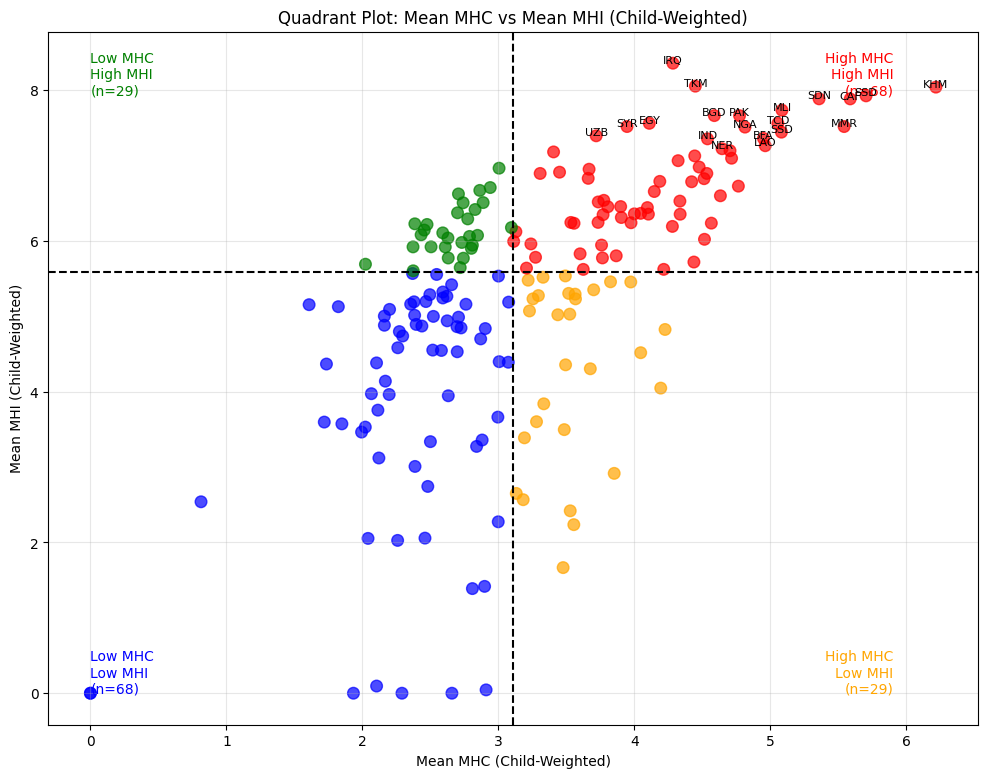

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# 1️⃣ Load GeoJSON (for filtering ISO3 only)
geojson_file = '/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/CCRI_P1_P2_format.geojson'
gdf = gpd.read_file(geojson_file)

# Clean iso3
gdf['iso3'] = gdf['iso3'].astype(str).str.strip()

# 2️⃣ Load combined MHC & MHI data
file_combined = '/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/Child_weighted_MHC_MHI_by_country_10_variables.csv'
df = pd.read_csv(file_combined, usecols=['ISO3', 'mean_MHC_child_weighted', 'mean_MHI_child_weighted'])

# 3️⃣ Filter only countries present in GeoJSON
df = df[df['ISO3'].isin(gdf['iso3'])]
df = df.merge(gdf[['iso3','adm_name', 'u18_pop']], left_on='ISO3', right_on='iso3', how='left')

# 4️⃣ Compute thresholds (median) for quadrants
x_thr = df['mean_MHC_child_weighted'].median()
y_thr = df['mean_MHI_child_weighted'].median()

# 5️⃣ Assign quadrant colors
def quadrant_color(x, y):
    if x >= x_thr and y >= y_thr:
        return 'red'    # High MHC, High MHI
    elif x >= x_thr and y < y_thr:
        return 'orange' # High MHC, Low MHI
    elif x < x_thr and y >= y_thr:
        return 'green'  # Low MHC, High MHI
    else:
        return 'blue'   # Low MHC, Low MHI

df['color'] = df.apply(lambda r: quadrant_color(r['mean_MHC_child_weighted'], r['mean_MHI_child_weighted']), axis=1)

# 6️⃣ Quadrant counts
counts = {
    'High-High': len(df[(df['mean_MHC_child_weighted'] >= x_thr) & (df['mean_MHI_child_weighted'] >= y_thr)]),
    'High-Low': len(df[(df['mean_MHC_child_weighted'] >= x_thr) & (df['mean_MHI_child_weighted'] < y_thr)]),
    'Low-High': len(df[(df['mean_MHC_child_weighted'] < x_thr) & (df['mean_MHI_child_weighted'] >= y_thr)]),
    'Low-Low': len(df[(df['mean_MHC_child_weighted'] < x_thr) & (df['mean_MHI_child_weighted'] < y_thr)])
}

# 7️⃣ Plot quadrant
plt.figure(figsize=(12, 9))
plt.scatter(df['mean_MHC_child_weighted'], df['mean_MHI_child_weighted'], c=df['color'], alpha=0.7, s=70)

# Quadrant lines
plt.axvline(x=x_thr, color='black', linestyle='--')
plt.axhline(y=y_thr, color='black', linestyle='--')

# Quadrant labels with counts
plt.text(df['mean_MHC_child_weighted'].max()*0.95, df['mean_MHI_child_weighted'].max()*0.95,
         f'High MHC\nHigh MHI\n(n={counts["High-High"]})', ha='right', fontsize=10, color='red')
plt.text(df['mean_MHC_child_weighted'].max()*0.95, df['mean_MHI_child_weighted'].min()*1.05,
         f'High MHC\nLow MHI\n(n={counts["High-Low"]})', ha='right', fontsize=10, color='orange')
plt.text(df['mean_MHC_child_weighted'].min()*1.05, df['mean_MHI_child_weighted'].max()*0.95,
         f'Low MHC\nHigh MHI\n(n={counts["Low-High"]})', ha='left', fontsize=10, color='green')
plt.text(df['mean_MHC_child_weighted'].min()*1.05, df['mean_MHI_child_weighted'].min()*1.05,
         f'Low MHC\nLow MHI\n(n={counts["Low-Low"]})', ha='left', fontsize=10, color='blue')

# Label top 20 countries by MHI
top20 = df.nlargest(20, 'mean_MHI_child_weighted')
for i, row in top20.iterrows():
    plt.text(row['mean_MHC_child_weighted'], row['mean_MHI_child_weighted'], row['ISO3'], fontsize=8, ha='center')

# Labels and title
plt.xlabel('Mean MHC (Child-Weighted)')
plt.ylabel('Mean MHI (Child-Weighted)')
plt.title('Quadrant Plot: Mean MHC vs Mean MHI (Child-Weighted)')

plt.grid(alpha=0.3)
plt.show()


In [10]:
df.to_csv('/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/Child_weighted_MHC_MHI_quadrant_figure.csv')

In [ ]:
df.to_csv('/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/Child_weighted_MHC_MHI_by_country_U18pop_10_variables.csv')

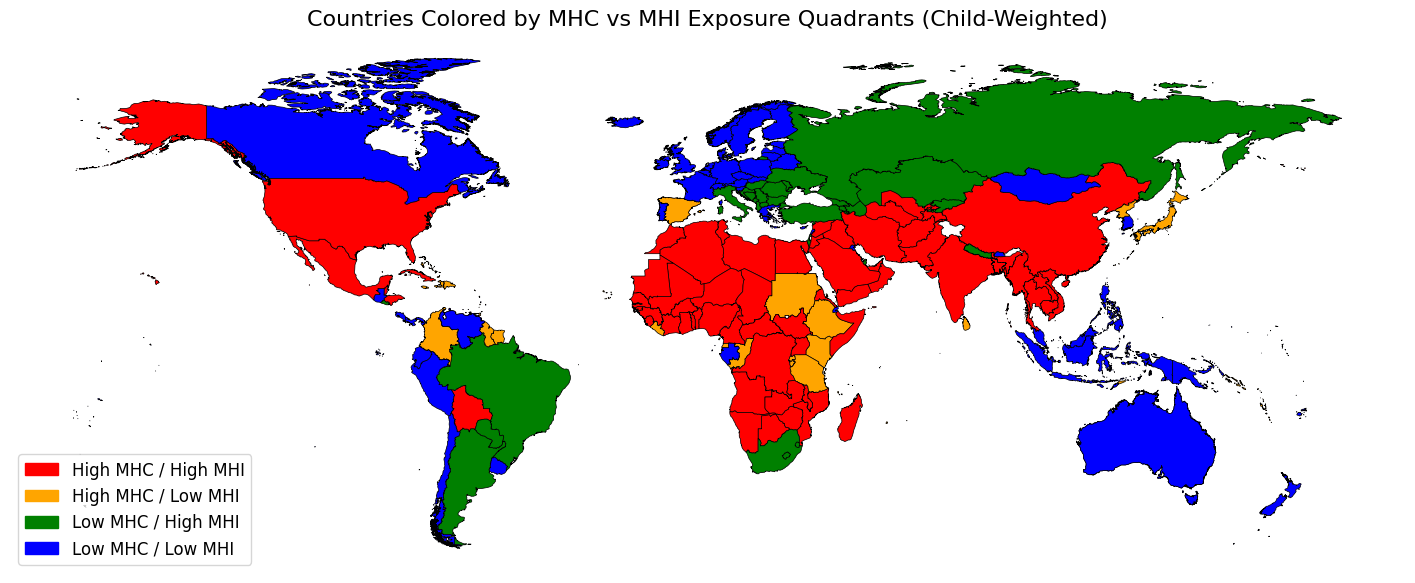

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

# 1️⃣ Load GeoJSON
geojson_file = '/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/CCRI_P1_P2_format.geojson'
gdf = gpd.read_file(geojson_file)

# Clean iso3
gdf['iso3'] = gdf['iso3'].astype(str).str.strip()

# 2️⃣ Load combined MHC & MHI data
file_combined = '/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/Child_weighted_MHC_MHI_by_country_10_variables.csv'
df = pd.read_csv(file_combined, usecols=['ISO3', 'mean_MHC_child_weighted', 'mean_MHI_child_weighted'])

# 3️⃣ Filter only countries present in GeoJSON
df = df[df['ISO3'].isin(gdf['iso3'])]

# 4️⃣ Compute thresholds (median)
x_thr = df['mean_MHC_child_weighted'].median()
y_thr = df['mean_MHI_child_weighted'].median()

# 5️⃣ Assign quadrant colors
def quadrant_color(x, y):
    if x >= x_thr and y >= y_thr:
        return 'red'    # High MHC, High MHI
    elif x >= x_thr and y < y_thr:
        return 'orange' # High MHC, Low MHI
    elif x < x_thr and y >= y_thr:
        return 'green'  # Low MHC, High MHI
    else:
        return 'blue'   # Low MHC, Low MHI

df['color'] = df.apply(lambda r: quadrant_color(r['mean_MHC_child_weighted'], r['mean_MHI_child_weighted']), axis=1)

# 6️⃣ Merge color info back to GeoDataFrame
gdf_merged = gdf.merge(df[['ISO3', 'mean_MHC_child_weighted', 'mean_MHI_child_weighted', 'color']],
                       left_on='iso3', right_on='ISO3', how='left')

# 7️⃣ Plot map
fig, ax = plt.subplots(1, 1, figsize=(18, 12))
gdf_merged.plot(color=gdf_merged['color'], edgecolor='black', linewidth=0.5, ax=ax)

# Optional: remove axes and add title
ax.set_axis_off()
plt.title('Countries Colored by MHC vs MHI Exposure Quadrants (Child-Weighted)', fontsize=16)

# 8️⃣ Add manual legend for quadrants
legend_patches = [
    mpatches.Patch(color='red', label='High MHC / High MHI'),
    mpatches.Patch(color='orange', label='High MHC / Low MHI'),
    mpatches.Patch(color='green', label='Low MHC / High MHI'),
    mpatches.Patch(color='blue', label='Low MHC / Low MHI'),
]
ax.legend(handles=legend_patches, loc='lower left', fontsize=12)

plt.show()


In [ ]:
import pandas as pd

# 1️⃣ Define mapping from color to quadrant
color_to_quadrant = {
    'red': 'High MHC / High MHI',
    'orange': 'High MHC / Low MHI',
    'green': 'Low MHC / High MHI',
    'blue': 'Low MHC / Low MHI'
}

# 2️⃣ Extract country name, ISO3, and quadrant
table_df = gdf_merged[['adm_name', 'ISO3', 'color']].dropna()
table_df['Quadrant'] = table_df['color'].map(color_to_quadrant)

# 3️⃣ Create the final table sorted by quadrant
result_table = table_df[['Quadrant', 'adm_name', 'ISO3']].sort_values(by=['Quadrant', 'adm_name'])

# 4️⃣ Display grouped by quadrant (optional)
grouped = result_table.groupby('Quadrant').apply(lambda x: x[['adm_name', 'ISO3']].values.tolist())

# Display
print(result_table)
print("\nGrouped by Quadrant:\n", grouped)

# Export to CSV
output_file = '/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/MHC_MHI_quadrant_table.csv'
result_table.to_csv(output_file, index=False)

print(f"CSV exported to: {output_file}")

                Quadrant                                           adm_name  \
2    High MHC / High MHI                                        Afghanistan   
46   High MHC / High MHI                                            Algeria   
20   High MHC / High MHI                                         Bangladesh   
19   High MHC / High MHI                                             Belize   
7    High MHC / High MHI                                              Benin   
..                   ...                                                ...   
54     Low MHC / Low MHI  United Kingdom of Great Britain & Northern Ire...   
174    Low MHC / Low MHI                        United Republic of Tanzania   
183    Low MHC / Low MHI                                            Uruguay   
181    Low MHC / Low MHI                                          Venezuela   
189    Low MHC / Low MHI                                              Yemen   

    ISO3  
2    AFG  
46   DZA  
20   BGD  
19   BL

/tmp/ipython-input-3905288263.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = result_table.groupby('Quadrant').apply(lambda x: x[['adm_name', 'ISO3']].values.tolist())


In [ ]:
p1 = gdf['P1_geometric_avg']
p2 = gdf['P2_arithmetic_avg']

In [ ]:
gdf['wb_income'].unique()

array(['HI', 'LMI', 'LI', 'UMI', None], dtype=object)

In [ ]:
gdf['type'].unique()

array(['State'], dtype=object)

In [ ]:
list(gdf.columns)

['iso3',
 'adm_name',
 'total_pop',
 'u18_pop',
 'wb_income',
 'unicef_ro',
 'ucode',
 'uuid',
 'type',
 'fragile',
 'rfl_abs',
 'rfl_rel',
 'rfl_abs_norm',
 'rfl_rel_norm',
 'cfl_abs',
 'cfl_rel',
 'cfl_abs_norm',
 'cfl_rel_norm',
 'ts_abs',
 'ts_rel',
 'ts_abs_norm',
 'ts_rel_norm',
 'agdr_abs',
 'agdr_rel',
 'agdr_abs_norm',
 'agdr_rel_norm',
 'metdr_spei_abs',
 'metdr_spei_rel',
 'metdr_spei_abs_norm',
 'metdr_spei_rel_norm',
 'metdr_spi_abs',
 'metdr_spi_rel',
 'metdr_spi_abs_norm',
 'metdr_spi_rel_norm',
 'hw_fre_abs',
 'hw_fre_rel',
 'hw_fre_abs_norm',
 'hw_fre_rel_norm',
 'hw_dur_abs',
 'hw_dur_rel',
 'hw_dur_abs_norm',
 'hw_dur_rel_norm',
 'hw_sev_abs',
 'hw_sev_rel',
 'hw_sev_abs_norm',
 'hw_sev_rel_norm',
 'ext_abs',
 'ext_rel',
 'ext_abs_norm',
 'ext_rel_norm',
 'fr_fre_abs',
 'fr_fre_rel',
 'fr_fre_abs_norm',
 'fr_fre_rel_norm',
 'fr_int_abs',
 'fr_int_rel',
 'fr_int_abs_norm',
 'fr_int_rel_norm',
 'sds_abs',
 'sds_rel',
 'sds_abs_norm',
 'sds_rel_norm',
 'pm25_abs',
 'pm2

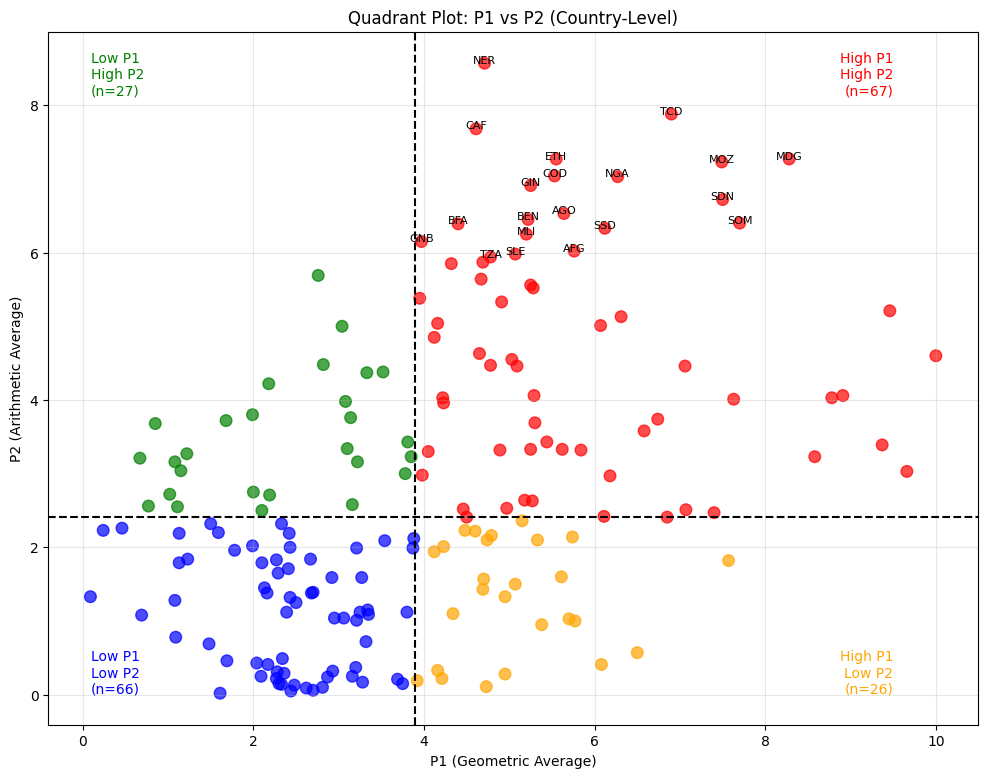

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# 1️⃣ Load GeoJSON
geojson_file = '/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/CCRI_P1_P2_format.geojson'
gdf = gpd.read_file(geojson_file)

# Clean iso3
gdf['iso3'] = gdf['iso3'].astype(str).str.strip()

# Extract P1 and P2
df = gdf[['iso3', 'P1_geometric_avg', 'P2_arithmetic_avg']].dropna()
df.rename(columns={'iso3': 'ISO3', 'P1_geometric_avg': 'P1', 'P2_arithmetic_avg': 'P2'}, inplace=True)

# 2️⃣ Compute thresholds (median) for quadrants
x_thr = df['P1'].median()
y_thr = df['P2'].median()

# 3️⃣ Assign quadrant colors
def quadrant_color(x, y):
    if x >= x_thr and y >= y_thr:
        return 'red'    # High P1, High P2
    elif x >= x_thr and y < y_thr:
        return 'orange' # High P1, Low P2
    elif x < x_thr and y >= y_thr:
        return 'green'  # Low P1, High P2
    else:
        return 'blue'   # Low P1, Low P2

df['color'] = df.apply(lambda r: quadrant_color(r['P1'], r['P2']), axis=1)

# 4️⃣ Quadrant counts
counts = {
    'High-High': len(df[(df['P1'] >= x_thr) & (df['P2'] >= y_thr)]),
    'High-Low': len(df[(df['P1'] >= x_thr) & (df['P2'] < y_thr)]),
    'Low-High': len(df[(df['P1'] < x_thr) & (df['P2'] >= y_thr)]),
    'Low-Low': len(df[(df['P1'] < x_thr) & (df['P2'] < y_thr)])
}

# 5️⃣ Plot quadrant
plt.figure(figsize=(12, 9))
plt.scatter(df['P1'], df['P2'], c=df['color'], alpha=0.7, s=70)

# Quadrant lines
plt.axvline(x=x_thr, color='black', linestyle='--')
plt.axhline(y=y_thr, color='black', linestyle='--')

# Quadrant labels with counts
plt.text(df['P1'].max()*0.95, df['P2'].max()*0.95,
         f'High P1\nHigh P2\n(n={counts["High-High"]})', ha='right', fontsize=10, color='red')
plt.text(df['P1'].max()*0.95, df['P2'].min()*1.05,
         f'High P1\nLow P2\n(n={counts["High-Low"]})', ha='right', fontsize=10, color='orange')
plt.text(df['P1'].min()*1.05, df['P2'].max()*0.95,
         f'Low P1\nHigh P2\n(n={counts["Low-High"]})', ha='left', fontsize=10, color='green')
plt.text(df['P1'].min()*1.05, df['P2'].min()*1.05,
         f'Low P1\nLow P2\n(n={counts["Low-Low"]})', ha='left', fontsize=10, color='blue')

# Label top 20 countries by P2
top20 = df.nlargest(20, 'P2')
for i, row in top20.iterrows():
    plt.text(row['P1'], row['P2'], row['ISO3'], fontsize=8, ha='center')

# Labels and title
plt.xlabel('P1 (Geometric Average)')
plt.ylabel('P2 (Arithmetic Average)')
plt.title('Quadrant Plot: P1 vs P2 (Country-Level)')

plt.grid(alpha=0.3)
plt.show()


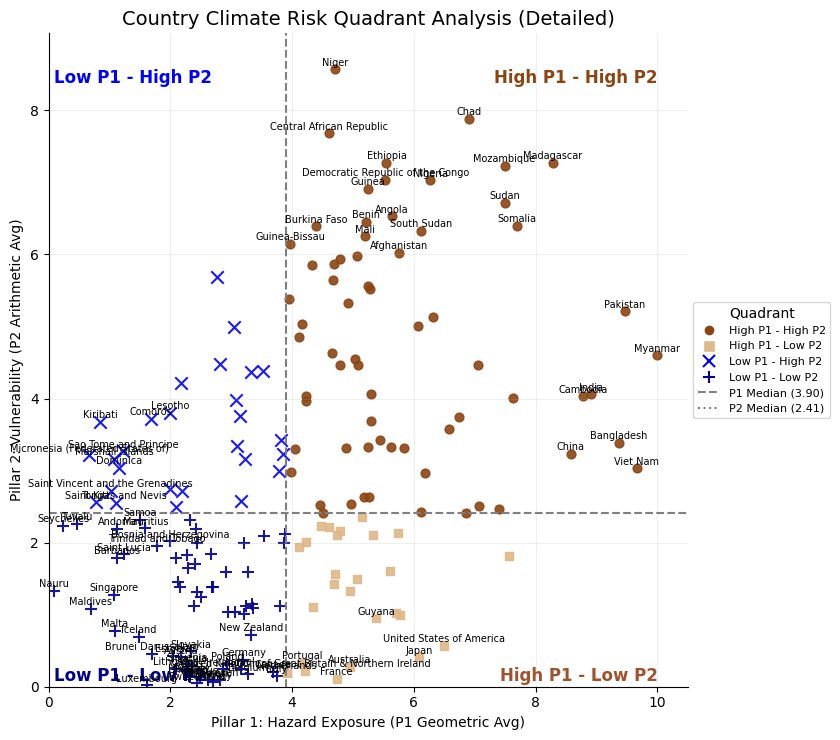

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# --- 1️⃣ Data Loading and Preparation ---
# NOTE: The GeoJSON file path is assumed to be correct and accessible.
geojson_file = '/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/CCRI_P1_P2_format.geojson'

# Attempt to load the actual data
try:
    gdf = gpd.read_file(geojson_file)

    # Clean iso3
    gdf['iso3'] = gdf['iso3'].astype(str).str.strip()

    # Extract P1, P2, and the country name from 'adm_name'
    # Assuming 'adm_name' exists in your GeoJSON as requested
    df = gdf[['iso3', 'P1_geometric_avg', 'P2_arithmetic_avg', 'adm_name']].dropna()
    df.rename(columns={'iso3': 'ISO3',
                        'P1_geometric_avg': 'P1',
                        'P2_arithmetic_avg': 'P2',
                        'adm_name': 'label'}, # Use 'label' for plotting consistency
                inplace=True)

except Exception as e:
    print(f"Error loading GeoJSON: {e}")
    # Fallback to dummy data for visualization example if file isn't available
    print("Using dummy data with explicit country names for visualization example.")
    data = {
        'ISO3': ['AFG', 'ZWE', 'USA', 'JPN', 'BRA', 'IND', 'ETH', 'TZA', 'BGD', 'TCD', 'CAF', 'MDG', 'GIN', 'SLE', 'ISL', 'SVK'],
        'P1': [8.5, 5.2, 5.5, 1.2, 3.5, 9.8, 4.1, 4.5, 9.5, 6.5, 4.5, 7.5, 4.8, 5.1, 1.0, 2.0],
        'P2': [4.1, 7.5, 1.0, 0.5, 2.1, 3.2, 5.1, 4.0, 2.5, 7.8, 7.5, 6.5, 6.0, 5.8, 0.2, 0.5],
        'label': ['Afghanistan', 'Zimbabwe', 'United States of America', 'Japan', 'Brazil', 'India', 'Ethiopia', 'Tanzania', 'Bangladesh', 'Chad', 'Central African Republic', 'Madagascar', 'Guinea', 'Sierra Leone', 'Iceland', 'Slovakia']
    }
    df = pd.DataFrame(data)

# --- 2️⃣ Compute thresholds (median) for quadrants ---
x_thr = df['P1'].median()
y_thr = df['P2'].median()

# Define the median values for the legend
p1_median_val = x_thr
p2_median_val = y_thr

# --- 3️⃣ Assign quadrant type, color, and marker to match the image ---
def quadrant_style(x, y):
    if x >= x_thr and y >= y_thr:
        # High P1 - High P2 (Top Right)
        return {'quadrant': 'High P1 - High P2', 'color': '#8B4513', 'marker': 'o'} # Brown circle
    elif x >= x_thr and y < y_thr:
        # High P1 - Low P2 (Bottom Right)
        return {'quadrant': 'High P1 - Low P2', 'color': '#DEB887', 'marker': 's'} # Light brown square
    elif x < x_thr and y >= y_thr:
        # Low P1 - High P2 (Top Left)
        return {'quadrant': 'Low P1 - High P2', 'color': 'blue', 'marker': 'x'} # Blue 'x'
    else:
        # Low P1 - Low P2 (Bottom Left)
        return {'quadrant': 'Low P1 - Low P2', 'color': 'darkblue', 'marker': '+'} # Dark blue cross

# Apply the style definition
styles = df.apply(lambda r: quadrant_style(r['P1'], r['P2']), axis=1, result_type='expand')
df = pd.concat([df, styles], axis=1)

# --- 4️⃣ Plotting ---
plt.figure(figsize=(10, 7.5))

# Plot each quadrant separately for a clean legend
quadrants = df['quadrant'].unique()
for quad in quadrants:
    subset = df[df['quadrant'] == quad]
    style = subset.iloc[0] # Get the style for this quadrant
    plt.scatter(
        subset['P1'],
        subset['P2'],
        c=style['color'],
        marker=style['marker'],
        label=quad,
        alpha=0.9,
        s=40 if style['marker'] in ['o', 's'] else 80
    )

# Quadrant lines: dashed, grey/black to match
plt.axvline(x=x_thr, color='gray', linestyle='--')
plt.axhline(y=y_thr, color='gray', linestyle='--')

# --- Quadrant Labels (Text Overlays as in the image) ---
p1_max = df['P1'].max()
p2_max = df['P2'].max()
p1_min = df['P1'].min()
p2_min = df['P2'].min()

# Top Right
plt.text(p1_max, p2_max, 'High P1 - High P2',
         ha='right', va='top', color='#8B4513', fontsize=12, fontweight='bold')
# Bottom Right
plt.text(p1_max, p2_min, 'High P1 - Low P2',
         ha='right', va='bottom', color='#A0522D', fontsize=12, fontweight='bold')
# Top Left
plt.text(p1_min, p2_max, 'Low P1 - High P2',
         ha='left', va='top', color='blue', fontsize=12, fontweight='bold')
# Bottom Left
plt.text(p1_min, p2_min, 'Low P1 - Low P2',
         ha='left', va='bottom', color='darkblue', fontsize=12, fontweight='bold')


# --- Country Labels (Using 'adm_name' via the 'label' column) ---
# To replicate the original plot's labeling, we'll label points near the extremes or the quadrant centers.
# This avoids hardcoding and still labels the most 'interesting' points.
# We'll label the top 5 by P1, top 5 by P2, and the 5 closest to the quadrant lines in each quadrant.

# List of all unique countries to potentially label
countries_to_label = set()

# 1. Top 5 countries by P1 and P2
countries_to_label.update(df.nlargest(5, 'P1')['label'].tolist())
countries_to_label.update(df.nlargest(5, 'P2')['label'].tolist())

# 2. Countries near the axes (P1 > 8 or P2 > 6 or P1 < 2 or P2 < 1)
countries_to_label.update(df[(df['P1'] > 8) | (df['P2'] > 6) | (df['P1'] < 2) | (df['P2'] < 1)]['label'].tolist())

# Convert to list and remove potential duplicates
countries_to_label = list(countries_to_label)

# Loop through the DataFrame to apply labels
for _, row in df.iterrows():
    # Only label the selected countries
    if row['label'] in countries_to_label:
        # Simple text placement, adjusted slightly above the point
        plt.text(row['P1'], row['P2'] + 0.05, row['label'], fontsize=7, ha='center')

# --- Labels, Title, and Legend ---
plt.xlabel('Pillar 1: Hazard Exposure (P1 Geometric Avg)')
plt.ylabel('Pillar 2: Vulnerability (P2 Arithmetic Avg)')
plt.title('Country Climate Risk Quadrant Analysis (Detailed)', fontsize=14)

# Create the custom legend
legend_elements = [
    # Quadrant Entries
    plt.Line2D([0], [0], marker='o', color='w', label='High P1 - High P2', markerfacecolor='#8B4513', markersize=8),
    plt.Line2D([0], [0], marker='s', color='w', label='High P1 - Low P2', markerfacecolor='#DEB887', markersize=8),
    plt.Line2D([0], [0], marker='x', color='blue', label='Low P1 - High P2', linestyle='None', markersize=8, markeredgewidth=1.5),
    plt.Line2D([0], [0], marker='+', color='darkblue', label='Low P1 - Low P2', linestyle='None', markersize=8, markeredgewidth=1.5),
    # Median Lines
    plt.Line2D([0], [0], color='gray', linestyle='--', label=f'P1 Median ({p1_median_val:.2f})'),
    plt.Line2D([0], [0], color='gray', linestyle=':', label=f'P2 Median ({p2_median_val:.2f})')
]

plt.legend(handles=legend_elements, title='Quadrant', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

# Set the limits to be slightly outside the data range
plt.xlim(left=max(0, df['P1'].min() - 0.5), right=df['P1'].max() + 0.5)
plt.ylim(bottom=max(0, df['P2'].min() - 0.5), top=df['P2'].max() + 0.5)

plt.grid(alpha=0.2, linestyle='-')

# Remove the top and right spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [9]:
df.to_csv('/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/quadrant_figure_16.csv')

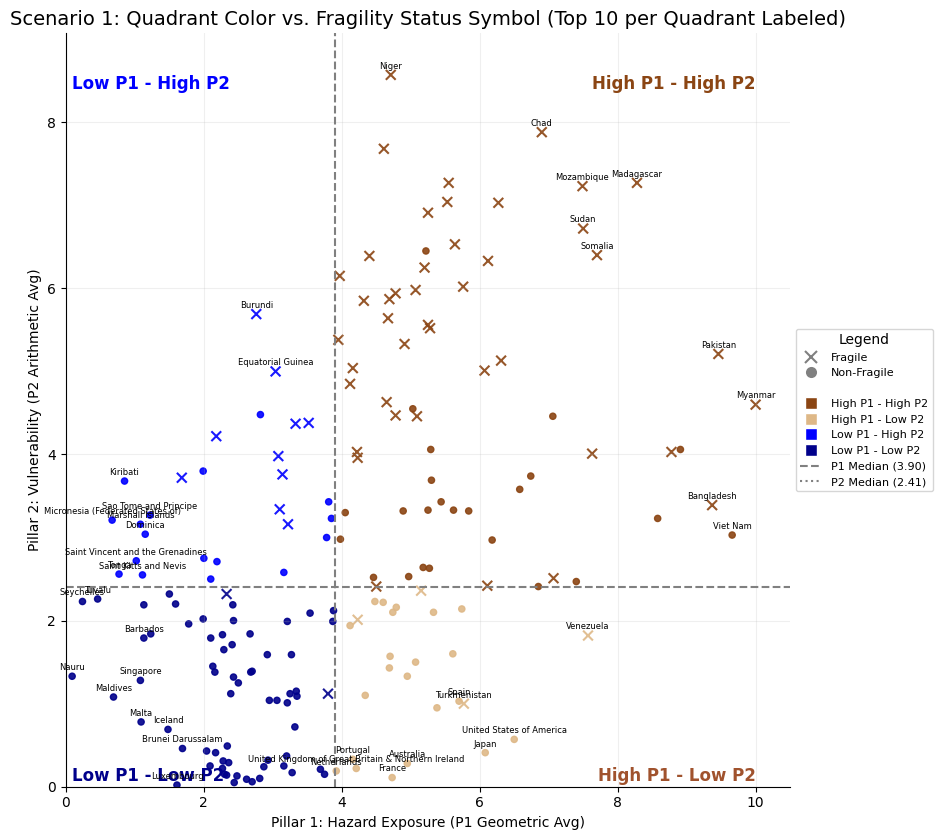


--- Plot for Scenario 1 Generated with 10 Labels per Quadrant ---


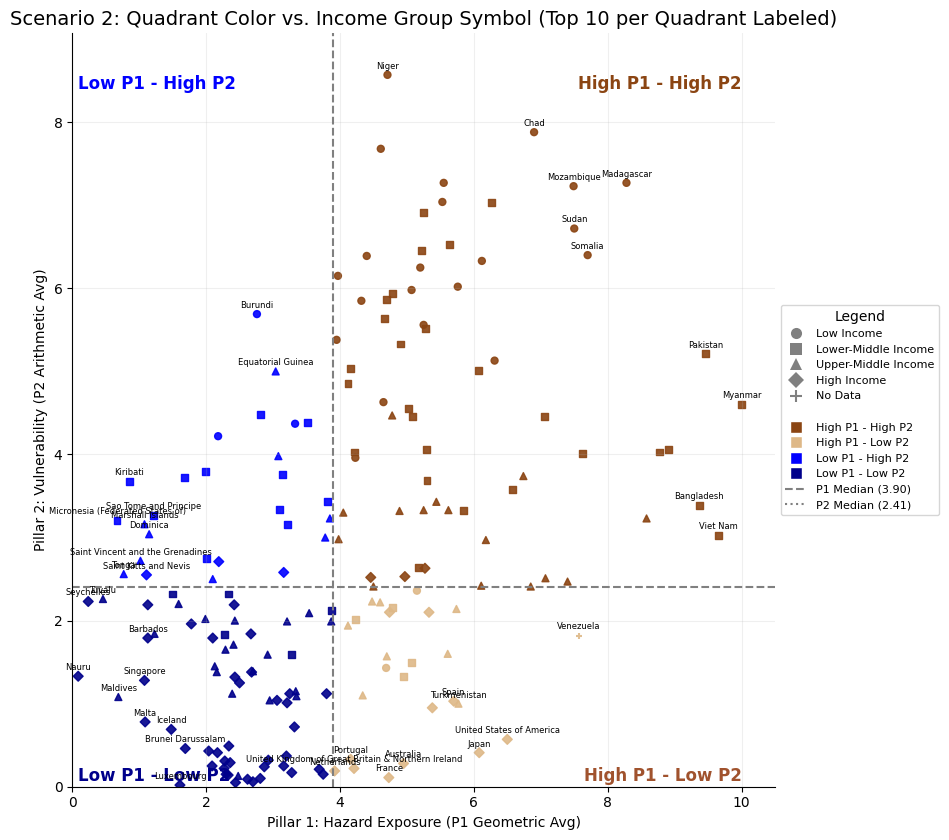


--- Plot for Scenario 2 Generated with 10 Labels per Quadrant ---


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

# --- 1️⃣ Data Loading and Preparation (Same as before) ---
geojson_file = '/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/CCRI_P1_P2_format.geojson'

try:
    gdf = gpd.read_file(geojson_file)
    gdf['iso3'] = gdf['iso3'].astype(str).str.strip()

    # Extract P1, P2, name, fragile status, and income group
    df = gdf[['iso3', 'P1_geometric_avg', 'P2_arithmetic_avg', 'adm_name', 'fragile', 'wb_income']].dropna(subset=['P1_geometric_avg', 'P2_arithmetic_avg'])
    df.rename(columns={'iso3': 'ISO3',
                        'P1_geometric_avg': 'P1',
                        'P2_arithmetic_avg': 'P2',
                        'adm_name': 'label'},
                inplace=True)

    # --- Data Cleaning for Symbols ---
    df['fragile_status'] = df['fragile'].apply(lambda x: 'Fragile' if x == 'fragile' else 'Non-Fragile')

    income_map = {
        'HI': 'High Income', 'UMI': 'Upper-Middle Income', 'LMI': 'Lower-Middle Income',
        'LI': 'Low Income', np.nan: 'No Data'
    }
    df['income_group'] = df['wb_income'].map(income_map).fillna('No Data')

except Exception as e:
    print(f"Error loading GeoJSON: {e}")
    # Fallback to rich dummy data for visualization example
    print("Using rich dummy data with required attributes for visualization example.")
    data = {
        'ISO3': ['AFG', 'ZWE', 'USA', 'JPN', 'ETH', 'TCD', 'CAF', 'ISL', 'SVK', 'MLT', 'SGP', 'DEU', 'NLD', 'BGD', 'IND', 'KIR', 'TUV', 'SOM', 'MDG', 'VEN', 'COL', 'THA', 'GNB', 'LSO', 'SDN', 'NGA', 'BDI', 'ECU', 'CHE', 'AUS'],
        'P1': [8.5, 5.2, 5.5, 1.2, 4.1, 6.5, 4.5, 0.5, 1.5, 0.8, 0.7, 1.8, 1.5, 9.5, 9.8, 1.5, 1.0, 7.0, 7.5, 6.5, 4.0, 6.5, 4.0, 2.5, 7.0, 5.5, 4.0, 3.5, 1.5, 4.5],
        'P2': [4.1, 7.5, 1.0, 0.5, 5.1, 7.8, 7.5, 0.2, 0.5, 0.1, 0.3, 0.9, 0.7, 2.5, 3.2, 4.5, 4.8, 6.5, 6.8, 2.0, 1.5, 1.8, 5.5, 4.0, 5.0, 6.0, 5.0, 4.5, 0.5, 1.0],
        'label': ['Afghanistan', 'Zimbabwe', 'USA', 'Japan', 'Ethiopia', 'Chad', 'C.A.R.', 'Iceland', 'Slovakia', 'Malta', 'Singapore', 'Germany', 'Netherlands', 'Bangladesh', 'India', 'Kiribati', 'Tuvalu', 'Somalia', 'Madagascar', 'Venezuela', 'Colombia', 'Thailand', 'G-Bissau', 'Lesotho', 'Sudan', 'Nigeria', 'Burundi', 'Ecuador', 'Switzerland', 'Australia'],
        'fragile_status': ['Fragile', 'Fragile', 'Non-Fragile', 'Non-Fragile', 'Fragile', 'Fragile', 'Fragile', 'Non-Fragile', 'Non-Fragile', 'Non-Fragile', 'Non-Fragile', 'Non-Fragile', 'Non-Fragile', 'Non-Fragile', 'Non-Fragile', 'Fragile', 'Fragile', 'Fragile', 'Fragile', 'Non-Fragile', 'Non-Fragile', 'Non-Fragile', 'Fragile', 'Fragile', 'Fragile', 'Fragile', 'Fragile', 'Non-Fragile', 'Non-Fragile', 'Non-Fragile'],
        'income_group': ['Low Income', 'Upper-Middle Income', 'High Income', 'High Income', 'Low Income', 'Low Income', 'Low Income', 'High Income', 'High Income', 'High Income', 'High Income', 'High Income', 'High Income', 'Lower-Middle Income', 'Lower-Middle Income', 'Low Income', 'Low Income', 'Low Income', 'Low Income', 'Upper-Middle Income', 'Upper-Middle Income', 'Upper-Middle Income', 'Low Income', 'Lower-Middle Income', 'Low Income', 'Low Income', 'Low Income', 'Upper-Middle Income', 'High Income', 'High Income']
    }
    df = pd.DataFrame(data)

# --- 2️⃣ Compute thresholds (median) for quadrants ---
x_thr = df['P1'].median()
y_thr = df['P2'].median()
p1_median_val = x_thr
p2_median_val = y_thr

# --- 3️⃣ Quadrant Color Definition (Fixed) ---
def quadrant_color(x, y):
    if x >= x_thr and y >= y_thr:
        return '#8B4513'  # Brown (High-High)
    elif x >= x_thr and y < y_thr:
        return '#DEB887'  # Light Brown (High-Low)
    elif x < x_thr and y >= y_thr:
        return 'blue'     # Blue (Low-High)
    else:
        return 'darkblue' # Dark Blue (Low-Low)

df['color'] = df.apply(lambda r: quadrant_color(r['P1'], r['P2']), axis=1)

# --- Shared Plotting Function (Modified for 10 labels per quadrant) ---
def create_quadrant_plot(df, marker_column, size_column, title, legend_symbol_map):
    plt.figure(figsize=(11, 8.5))

    # Plotting loop: color by quadrant, symbol by marker_column
    groups = df[marker_column].unique()
    for group in groups:
        subset = df[df[marker_column] == group]
        marker_style = subset.iloc[0]['marker_style']
        size_style = subset.iloc[0][size_column]

        plt.scatter(
            subset['P1'],
            subset['P2'],
            c=subset['color'],
            marker=marker_style,
            label=group,
            alpha=0.9,
            s=size_style
        )

    # Quadrant lines and Text Labels
    plt.axvline(x=x_thr, color='gray', linestyle='--')
    plt.axhline(y=y_thr, color='gray', linestyle='--')

    p1_max, p2_max = df['P1'].max(), df['P2'].max()
    p1_min, p2_min = df['P1'].min(), df['P2'].min()
    plt.text(p1_max, p2_max, 'High P1 - High P2', ha='right', va='top', color='#8B4513', fontsize=12, fontweight='bold')
    plt.text(p1_max, p2_min, 'High P1 - Low P2', ha='right', va='bottom', color='#A0522D', fontsize=12, fontweight='bold')
    plt.text(p1_min, p2_max, 'Low P1 - High P2', ha='left', va='top', color='blue', fontsize=12, fontweight='bold')
    plt.text(p1_min, p2_min, 'Low P1 - Low P2', ha='left', va='bottom', color='darkblue', fontsize=12, fontweight='bold')

    # ----------------------------------------------------
    # 🌟 NEW LABELING LOGIC: Top 10 countries in each quadrant 🌟
    # ----------------------------------------------------

    # Calculate "extremity" distance for each quadrant (Euclidean distance from the center intersection)
    # The quadrant definition ensures the sign of the difference is appropriate for the distance calculation

    # High P1 - High P2 (Top Right)
    df['dist_TR'] = np.where((df['P1'] >= x_thr) & (df['P2'] >= y_thr),
                            np.sqrt((df['P1'] - x_thr)**2 + (df['P2'] - y_thr)**2), 0)

    # High P1 - Low P2 (Bottom Right)
    df['dist_BR'] = np.where((df['P1'] >= x_thr) & (df['P2'] < y_thr),
                            np.sqrt((df['P1'] - x_thr)**2 + (y_thr - df['P2'])**2), 0)

    # Low P1 - High P2 (Top Left)
    df['dist_TL'] = np.where((df['P1'] < x_thr) & (df['P2'] >= y_thr),
                            np.sqrt((x_thr - df['P1'])**2 + (df['P2'] - y_thr)**2), 0)

    # Low P1 - Low P2 (Bottom Left)
    df['dist_BL'] = np.where((df['P1'] < x_thr) & (df['P2'] < y_thr),
                            np.sqrt((x_thr - df['P1'])**2 + (y_thr - df['P2'])**2), 0)

    # Select the top 10 most extreme countries for each quadrant
    N = 10
    countries_to_label = set()
    countries_to_label.update(df.nlargest(N, 'dist_TR')['label'].tolist())
    countries_to_label.update(df.nlargest(N, 'dist_BR')['label'].tolist())
    countries_to_label.update(df.nlargest(N, 'dist_TL')['label'].tolist())
    countries_to_label.update(df.nlargest(N, 'dist_BL')['label'].tolist())

    countries_to_label = [c for c in countries_to_label if pd.notna(c)] # Filter out potential NaNs

    # Text Staggering Logic for the crowded bottom-left quadrant (P1 < 2.5)

    # Pre-filter for countries that are in the congested area AND should be labeled
    congested_df = df[(df['P1'] < 2.5) & (df['label'].isin(countries_to_label))].sort_values(by='P2', ascending=False)

    labeled_positions = []
    y_offset_step = 0.1 # Reduced vertical offset for tighter packing

    for _, row in df.iterrows():
        if row['label'] in countries_to_label:
            x_pos = row['P1']
            y_pos = row['P2'] + 0.05 # Initial offset above the point

            # Apply staggering only if in the congested zone
            if x_pos < 2.5:
                # Check for vertical overlap with existing labels
                for lx, ly in labeled_positions:
                    # Check for overlap in a small box around the point
                    if abs(y_pos - ly) < y_offset_step and abs(x_pos - lx) < 0.2:
                        y_pos -= y_offset_step
                        break

            # Use smaller font size (6)
            plt.text(x_pos, y_pos, row['label'], fontsize=6, ha='center', va='bottom')
            labeled_positions.append((x_pos, y_pos))


    # --- Labels, Title, and Legend ---
    plt.xlabel('Pillar 1: Hazard Exposure (P1 Geometric Avg)')
    plt.ylabel('Pillar 2: Vulnerability (P2 Arithmetic Avg)')
    plt.title(title, fontsize=14)

    # Custom Legend Elements (No size change here, keep legible)
    legend_elements = []

    for name, marker in legend_symbol_map.items():
        line = plt.Line2D([0], [0], marker=marker, color='w', label=name, markerfacecolor='gray', markersize=8,
                          linestyle='None', markeredgecolor='gray', markeredgewidth=1.5 if marker in ['x', '+'] else 0)
        legend_elements.append(line)

    legend_elements.append(plt.Line2D([0], [0], color='w', linestyle='-', label=''))

    legend_elements.append(plt.Line2D([0], [0], marker='s', color='w', label='High P1 - High P2', markerfacecolor='#8B4513', markersize=8))
    legend_elements.append(plt.Line2D([0], [0], marker='s', color='w', label='High P1 - Low P2', markerfacecolor='#DEB887', markersize=8))
    legend_elements.append(plt.Line2D([0], [0], marker='s', color='w', label='Low P1 - High P2', markerfacecolor='blue', markersize=8))
    legend_elements.append(plt.Line2D([0], [0], marker='s', color='w', label='Low P1 - Low P2', markerfacecolor='darkblue', markersize=8))

    legend_elements.append(plt.Line2D([0], [0], color='gray', linestyle='--', label=f'P1 Median ({p1_median_val:.2f})'))
    legend_elements.append(plt.Line2D([0], [0], color='gray', linestyle=':', label=f'P2 Median ({p2_median_val:.2f})'))

    plt.legend(handles=legend_elements, title='Legend', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

    plt.xlim(left=max(0, df['P1'].min() - 0.5), right=df['P1'].max() + 0.5)
    plt.ylim(bottom=max(0, df['P2'].min() - 0.5), top=df['P2'].max() + 0.5)
    plt.grid(alpha=0.2, linestyle='-')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# ----------------------------------------------------
# Scenario 1 Execution: Quadrant Color vs. Fragility Symbol
# ----------------------------------------------------

# Smaller Marker Sizes
df['marker_style'] = np.where(df['fragile_status'] == 'Fragile', 'x', 'o')
df['size_s1'] = np.where(df['fragile_status'] == 'Fragile', 50, 20)

fragile_legend_map = {
    'Fragile': 'x',
    'Non-Fragile': 'o'
}

create_quadrant_plot(
    df,
    marker_column='fragile_status',
    size_column='size_s1',
    title='Scenario 1: Quadrant Color vs. Fragility Status Symbol (Top 10 per Quadrant Labeled)',
    legend_symbol_map=fragile_legend_map
)
df.to_csv('/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/quadrant_figure_p63-1.csv')
print("\n--- Plot for Scenario 1 Generated with 10 Labels per Quadrant ---")

# ----------------------------------------------------
# Scenario 2 Execution: Quadrant Color vs. Income Group Symbol
# ----------------------------------------------------

income_marker_map = {
    'Low Income': 'o', 'Lower-Middle Income': 's', 'Upper-Middle Income': '^',
    'High Income': 'D', 'No Data': '+'
}

df['marker_style'] = df['income_group'].map(income_marker_map)
df['size_s2'] = 25

income_legend_map = {
    'Low Income': 'o', 'Lower-Middle Income': 's', 'Upper-Middle Income': '^',
    'High Income': 'D', 'No Data': '+'
}

create_quadrant_plot(
    df,
    marker_column='income_group',
    size_column='size_s2',
    title='Scenario 2: Quadrant Color vs. Income Group Symbol (Top 10 per Quadrant Labeled)',
    legend_symbol_map=income_legend_map
)

print("\n--- Plot for Scenario 2 Generated with 10 Labels per Quadrant ---")
df.to_csv('/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/quadrant_figure_p63-2.csv')

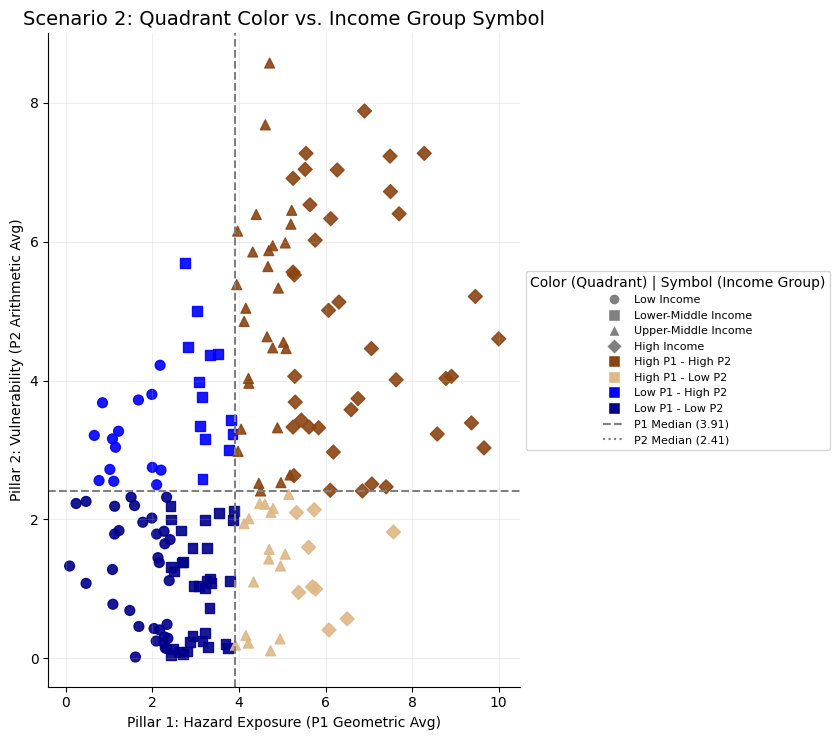


--- Plot for Scenario 2 (Quadrant Color, Income Group Symbol) Generated ---


In [ ]:
# --- SCENARIO 2: Marker = Income Group ---

# 1. Define markers for the four income groups
income_marker_map = {
    'Low': 'o',          # Circle
    'Lower-Middle': 's', # Square
    'Upper-Middle': '^', # Triangle
    'High': 'D'          # Diamond
}

df['marker_s2'] = df['income_group'].map(income_marker_map)
df['size_s2'] = 50 # Keep size uniform

# ----------------------------------------------------
# 2. Plotting for Scenario 2
# ----------------------------------------------------
plt.figure(figsize=(10, 7.5))

income_groups = sorted(df['income_group'].unique()) # Ensure sorted for clean legend

for group in income_groups:
    subset_group = df[df['income_group'] == group]
    marker_style = subset_group.iloc[0]['marker_s2']

    # Plot all points for this income group, using quadrant color
    plt.scatter(
        subset_group['P1'],
        subset_group['P2'],
        c=subset_group['color'],   # Use quadrant color
        marker=marker_style,       # Use income group symbol
        label=group,               # Use income group for legend entry
        alpha=0.9,
        s=df['size_s2'].iloc[0]
    )

# Quadrant lines and Labels
plt.axvline(x=x_thr, color='gray', linestyle='--')
plt.axhline(y=y_thr, color='gray', linestyle='--')
# ... [Quadrant Text Labels are omitted for brevity, but would be here] ...

# --- Labels, Title, and Legend ---
plt.xlabel('Pillar 1: Hazard Exposure (P1 Geometric Avg)')
plt.ylabel('Pillar 2: Vulnerability (P2 Arithmetic Avg)')
plt.title('Scenario 2: Quadrant Color vs. Income Group Symbol', fontsize=14)

# Custom Legend for Quadrants AND Symbols
legend_elements_s2 = [
    # Income Group Symbols
    plt.Line2D([0], [0], marker='o', color='w', label='Low Income', markerfacecolor='gray', markersize=8),
    plt.Line2D([0], [0], marker='s', color='w', label='Lower-Middle Income', markerfacecolor='gray', markersize=8),
    plt.Line2D([0], [0], marker='^', color='w', label='Upper-Middle Income', markerfacecolor='gray', markersize=8),
    plt.Line2D([0], [0], marker='D', color='w', label='High Income', markerfacecolor='gray', markersize=8),
    # Quadrant Colors
    plt.Line2D([0], [0], marker='s', color='w', label='High P1 - High P2', markerfacecolor='#8B4513', markersize=8),
    plt.Line2D([0], [0], marker='s', color='w', label='High P1 - Low P2', markerfacecolor='#DEB887', markersize=8),
    plt.Line2D([0], [0], marker='s', color='w', label='Low P1 - High P2', markerfacecolor='blue', markersize=8),
    plt.Line2D([0], [0], marker='s', color='w', label='Low P1 - Low P2', markerfacecolor='darkblue', markersize=8),
    # Median Lines
    plt.Line2D([0], [0], color='gray', linestyle='--', label=f'P1 Median ({p1_median_val:.2f})'),
    plt.Line2D([0], [0], color='gray', linestyle=':', label=f'P2 Median ({p2_median_val:.2f})')
]

plt.legend(handles=legend_elements_s2, title='Color (Quadrant) | Symbol (Income Group)', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

plt.grid(alpha=0.2, linestyle='-')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

print("\n--- Plot for Scenario 2 (Quadrant Color, Income Group Symbol) Generated ---")

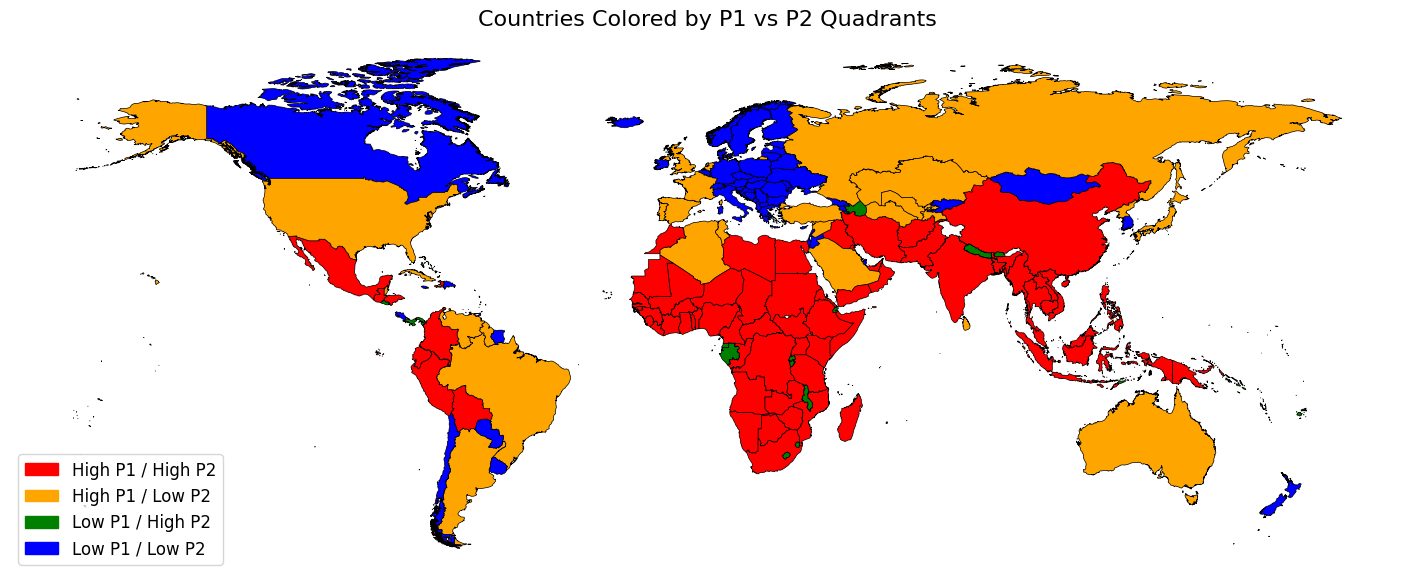

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 1️⃣ Load GeoJSON
geojson_file = '/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/CCRI_P1_P2_format.geojson'
gdf = gpd.read_file(geojson_file)

# Clean iso3
gdf['iso3'] = gdf['iso3'].astype(str).str.strip()

# Extract P1 and P2
df = gdf[['iso3', 'P1_geometric_avg', 'P2_arithmetic_avg']].dropna()
df.rename(columns={'iso3': 'ISO3', 'P1_geometric_avg': 'P1', 'P2_arithmetic_avg': 'P2'}, inplace=True)

# 2️⃣ Compute thresholds (median)
x_thr = df['P1'].median()
y_thr = df['P2'].median()

# 3️⃣ Assign quadrant colors
def quadrant_color(x, y):
    if x >= x_thr and y >= y_thr:
        return 'red'    # High P1, High P2
    elif x >= x_thr and y < y_thr:
        return 'orange' # High P1, Low P2
    elif x < x_thr and y >= y_thr:
        return 'green'  # Low P1, High P2
    else:
        return 'blue'   # Low P1, Low P2

df['color'] = df.apply(lambda r: quadrant_color(r['P1'], r['P2']), axis=1)

# 4️⃣ Merge color info back to GeoDataFrame
gdf_merged = gdf.merge(df[['ISO3', 'P1', 'P2', 'color']], left_on='iso3', right_on='ISO3', how='left')

# 5️⃣ Plot map
fig, ax = plt.subplots(1, 1, figsize=(18, 12))
gdf_merged.plot(color=gdf_merged['color'], edgecolor='black', linewidth=0.5, ax=ax)

# Remove axes and add title
ax.set_axis_off()
plt.title('Countries Colored by P1 vs P2 Quadrants', fontsize=16)

# 6️⃣ Add manual legend for quadrants
legend_patches = [
    mpatches.Patch(color='red', label='High P1 / High P2'),
    mpatches.Patch(color='orange', label='High P1 / Low P2'),
    mpatches.Patch(color='green', label='Low P1 / High P2'),
    mpatches.Patch(color='blue', label='Low P1 / Low P2'),
]
ax.legend(handles=legend_patches, loc='lower left', fontsize=12)

plt.show()


In [ ]:
import pandas as pd

# 1️⃣ Define mapping from color to quadrant
color_to_quadrant = {
    'red': 'High P1 / High P2',
    'orange': 'High P1 / Low P2',
    'green': 'Low P1 / High P2',
    'blue': 'Low P1 / Low P2'
}

# 2️⃣ Extract country name, ISO3, and quadrant
table_df = gdf_merged[['adm_name', 'ISO3', 'color']].dropna()
table_df['Quadrant'] = table_df['color'].map(color_to_quadrant)

# 3️⃣ Create the final table sorted by quadrant
result_table = table_df[['Quadrant', 'adm_name', 'ISO3']].sort_values(by=['Quadrant', 'adm_name'])

# 4️⃣ Display grouped by quadrant (optional)
grouped = result_table.groupby('Quadrant').apply(lambda x: x[['adm_name', 'ISO3']].values.tolist())

# Display
print(result_table)
print("\nGrouped by Quadrant:\n", grouped)

# Export to CSV
output_file = '/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/ccri_quadrant_table.csv'
result_table.to_csv(output_file, index=False)

print(f"CSV exported to: {output_file}")

              Quadrant                          adm_name ISO3
2    High P1 / High P2                       Afghanistan  AFG
1    High P1 / High P2                            Angola  AGO
19   High P1 / High P2                        Bangladesh  BGD
7    High P1 / High P2                             Benin  BEN
17   High P1 / High P2  Bolivia (Plurinational State of)  BOL
..                 ...                               ...  ...
23     Low P1 / Low P2                       Switzerland  CHE
164    Low P1 / Low P2               Trinidad and Tobago  TTO
169    Low P1 / Low P2                            Tuvalu  TUV
168    Low P1 / Low P2                           Ukraine  UKR
175    Low P1 / Low P2                           Uruguay  URY

[186 rows x 3 columns]

Grouped by Quadrant:
 Quadrant
High P1 / High P2    [[Afghanistan, AFG], [Angola, AGO], [Banglades...
High P1 / Low P2     [[Algeria, DZA], [Argentina, ARG], [Australia,...
Low P1 / High P2     [[Azerbaijan, AZE], [Bahamas, BHS], [

/tmp/ipython-input-1360711690.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = result_table.groupby('Quadrant').apply(lambda x: x[['adm_name', 'ISO3']].values.tolist())


,Quadrant,adm_name,ISO3
2,High P1 / High P2,Afghanistan,AFG
1,High P1 / High P2,Angola,AGO
19,High P1 / High P2,Bangladesh,BGD
7,High P1 / High P2,Benin,BEN
17,High P1 / High P2,Bolivia (Plurinational State of),BOL
...,...,...,...
23,Low P1 / Low P2,Switzerland,CHE
164,Low P1 / Low P2,Trinidad and Tobago,TTO
169,Low P1 / Low P2,Tuvalu,TUV
168,Low P1 / Low P2,Ukraine,UKR
